In [1]:
from collections import Counter
from tqdm import tqdm 
from colorama import Style,Fore
import os
from dotenv import load_dotenv
import json
import time
load_dotenv()

True

In [2]:
def openJson(path):
    with open(path, "r", encoding="utf-8") as file:
        data = json.load(file)
    return data

def saveJson(path,data):
    with open(path, "w", encoding="utf-8") as f:
       json.dump(data, f, ensure_ascii=False, indent=2)
       print(Style.BRIGHT+Fore.GREEN+'\n json saved'+Style.RESET_ALL)

# Short Bio probleme resolution

In [44]:
channelsF2 = openJson("../jsons/channelsF2.json")
len(channelsF2)

1836

In [ ]:
import matplotlib.pyplot as plt

plages = {
    '0-10': 0,
    '10-50': 0,
    '50-100': 0,
    '>100': 0
}

for item in channelsF2:
    bio = item.get('bio', '').strip()
    nb_mots = len(bio.split())
    
    if nb_mots <= 10:
        plages['0-10'] += 1
    elif nb_mots <= 50:
        plages['10-50'] += 1
    elif nb_mots <= 100:
        plages['50-100'] += 1
    else:
        plages['>100'] += 1

labels = list(plages.keys())
counts = list(plages.values())
total = sum(counts)
percentages = [count / total * 100 for count in counts]

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color='skyblue')

for bar, pct in zip(bars, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height, f'{pct:.1f}%', 
            ha='center', va='bottom', fontsize=10)

plt.xlabel('Plage de nombre de mots dans le bio')
plt.ylabel('Nombre de chaînes')
plt.title('Distribution des chaînes selon la longueur du bio')
plt.show()


In [45]:
from scrapetube import get_channel
from googleapiclient.discovery import build

def getContext(channel_id):
    api_key = os.getenv("YOUTUBE_API_KEY2")
    youtube = build('youtube', 'v3', developerKey=api_key)

    video_ids = []
    for video in get_channel(channel_id, limit=3, sort_by='newest', content_type='videos'):
        video_ids.append(video['videoId'])

    if not video_ids:
        return "No videos found."

    request = youtube.videos().list(part='snippet', id=','.join(video_ids))
    response = request.execute()

    combined = ""
    for item in response['items']:
        title = item['snippet'].get('title', 'No title')
        description = item['snippet'].get('description', 'No description')
        tags = ', '.join(item['snippet'].get('tags', [])) if 'tags' in item['snippet'] else 'No tags'

        combined += f"Title: {title}\nDescription: {description}\nTags: {tags}\n\n"

    return combined


In [ ]:
temp = 0
for item in tqdm(channelsF2):
    bio = item.get('bio', '').strip()
    nb_mots = len(bio.split())
    
    if nb_mots <= 100 :
        context = getContext(item['id_chaine'])
        item['context'] = context
        
    temp+=1
    if temp >= 100:
        saveJson("../jsons/channelsF2.json",channelsF2)
        temp = 0
   
saveJson("../jsons/channelsF2.json",channelsF2)

# 1.Echantillon

In [ ]:
import random

random.seed(42)
echantillon = random.sample(channelsF2, 200)

for item in echantillon:
    item['link']=f"https://www.youtube.com/channel/{item['id_chaine']}"
    item['pertinente']=""
    
saveJson("../jsons/echantillon.json",echantillon)
print(len(echantillon))

# 2.Manuel Validation 

In [4]:
echantillon = openJson("../jsons/echantillon.json")
len(echantillon)

200

In [5]:
valeurs = [item.get("pertinente") for item in echantillon]
compteur = Counter(valeurs)

for valeur, nb in compteur.items():
    print(f"{valeur} → {nb} chaines")

non → 166 chaines
oui → 34 chaines


# 3.With LLM

In [30]:
from langchain_google_genai import GoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate

In [31]:
gemini_flash_1 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_1"))
gemini_flash_2 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_2"))
gemini_flash_3 = GoogleGenerativeAI(model="gemini-2.0-flash", google_api_key=os.getenv("GOOGLE_API_KEY_3"))

In [32]:
sysprompt2 = """
# Définition de l’autosuffisance

L'autosuffisance est une démarche visant à acquérir la capacité de subvenir par soi-même à ses besoins fondamentaux,  
en priorité alimentaires, par l'autoconsommation – c'est-à-dire produire, récolter et conserver un maximum de sa propre nourriture,  
souvent en privilégiant le bio, le local et le saisonnier.

Elle dépasse la simple autonomie matérielle : c’est un engagement volontaire pour réduire sa dépendance au système économique et social extérieur.  
Cela implique des choix concrets : trouver un lieu adapté, l’aménager (par exemple en permaculture), repenser sa manière de consommer et de gérer son temps, pour construire une vie plus autonome.

---

# Votre mission

Décider si une chaîne est directement liée à la thématique de l’autosuffisance, en se basant sur un des deux contextes suivants :
- **context** = nom de la chaîne + bio
- OU  
- **context** = nom de la chaîne + bio + titres, descriptions et tags des trois dernières vidéos (si la bio est courte ou vide)

---

# Critères de décision

## Répondre **"oui"** uniquement si la chaîne est portée par :

- Des personnes ou des groupes qui cherchent à devenir autonomes (énergie, alimentation, habitat, etc.),  
  soit à titre **individuel** (seuls ou en famille),  soit de manière **auto-organisée** (collectifs informels, association ...).

Et uniquement si le contenu est **centré sur l’autosuffisance** :  

potager, autonomie alimentaire, autonomie énergétique, conservation, vie autonome, permaculture, etc.

## La présence de mots-clés comme :  

**autosuffisance**, **autosuffisant**, **autonomie**, **vie autonome**, **autonomie alimentaire**, **autonomie énergétique**  

est un bon indicateur.

## Exclure systématiquement :

- Les chaînes d'entreprises, d’institutions ou de structures commerciales (À but lucratif).
- Les chaînes d’agriculture générale, de jardinage standard ou de permaculture académique, **si elles ne sont pas clairement orientées vers une démarche d’autosuffisance personnelle ou collective non institutionnelle**.

---

# Format attendu

Répondre dans ce format JSON :

  "decision": "oui" ou "non",
  "justification": "Justifiez votre décision avec des arguments clairs, en vous basant uniquement sur les critères définis ci-dessus."

"""


In [33]:
sysprompt = """
# Définition de l’autosuffisance

L'autosuffisance est une démarche visant à acquérir la capacité de subvenir par soi-même à ses besoins fondamentaux,  
en priorité alimentaires, par l'autoconsommation – c'est-à-dire produire, récolter et conserver un maximum de sa propre nourriture,  
souvent en privilégiant le bio, le local et le saisonnier.

Elle dépasse la simple autonomie matérielle : c’est un engagement volontaire pour réduire sa dépendance au système économique et social extérieur.  
Cela implique des choix concrets : trouver un lieu adapté, l’aménager (par exemple en permaculture), repenser sa manière de consommer et de gérer son temps, pour construire une vie plus autonome.

---

# Votre mission

Décider si une chaîne est directement liée à la thématique de l’autosuffisance, en se basant sur un des deux contextes suivants :
- **context** = nom de la chaîne + bio
- OU  
- **context** = nom de la chaîne + bio + titres, descriptions et tags des trois dernières vidéos (si la bio est courte ou vide)

---

# Critères de décision

## Répondre **"oui"** uniquement si la chaîne est portée par :

- Des personnes ou des groupes qui cherchent à devenir autonomes (énergie, alimentation, habitat, etc.),  
  soit à titre **individuel** (seuls ou en famille),  soit de manière **auto-organisée** (collectifs informels, association ...).

Et uniquement si le contenu est **centré sur l’autosuffisance** :  

potager, autonomie alimentaire, autonomie énergétique, conservation, vie autonome, permaculture, etc.

## La présence de mots-clés comme :  

**autosuffisance**, **autosuffisant**, **autonomie**, **vie autonome**, **autonomie alimentaire**, **autonomie énergétique**  

est un bon indicateur.

## Exclure systématiquement :

- Les chaînes d'entreprises, d’institutions ou de structures commerciales (À but lucratif).
- Les chaînes d’agriculture générale, de jardinage standard ou de permaculture académique, **si elles ne sont pas clairement orientées vers une démarche d’autosuffisance personnelle ou collective non institutionnelle**.

---

# Format attendu

Répondre dans ce format JSON :

{
  "decision": "oui" ou "non",
  "justification": "Justifiez votre décision avec des arguments clairs, en vous basant uniquement sur les critères définis ci-dessus."
}
"""

userprompt = """
Le context ici
---
{context}

"""

prompt = ChatPromptTemplate([
    ("system", sysprompt2),
    ("user", userprompt)
])

chain_1 = prompt | gemini_flash_1
chain_2 = prompt | gemini_flash_2
chain_3 = prompt | gemini_flash_3


## Test

In [34]:
llmInput = "\n                              Nom Chaine :\n                              ---\n                              L’Ôton’home\n                              \n                              Bio Chaine :\n                              ---\n                              Nous sommes un couple parent de 2 jeunes garçons et avons acheté à l’été 2020 une GRANDE GRANGE sur un peu plus de 3 hectares de terrain dans le Tarn. Notre objectif: transformer cette grange en HABITATION la plus AUTONOME possible, ce par nos propres moyens, et en faire notre petit paradis. Venez partager notre aventure et suivre ce projet un peu fou ici.\n\nLe but de notre chaîne: montrer toutes les étapes de la TRANSFORMATION de la GRANGE en HABITATION, échanger sur l’AUTONOMIE, partager nos DIY en matière de PRODUITS MÉNAGERS et COSMÉTIQUES, toujours dans une optique d’AUTONOMIE.\n\nPrécision importante: nous ne sommes PAS des professionnels du bâtiment donc nos vidéos n'ont pas valeur de tutoriels mais de simples partages d'expérience.\n\nN’hésitez pas à laisser vos commentaires et à vous abonner à la chaîne. Vous pouvez également nous retrouver sur Facebook et Tipeee. En espérant pouvoir vous inspirer.\n\nDes bises,\n\nAurélie & David \n                            ",
input = {"context":llmInput}
print(input)
print(chain_1.invoke(input))

{'context': ("\n                              Nom Chaine :\n                              ---\n                              L’Ôton’home\n                              \n                              Bio Chaine :\n                              ---\n                              Nous sommes un couple parent de 2 jeunes garçons et avons acheté à l’été 2020 une GRANDE GRANGE sur un peu plus de 3 hectares de terrain dans le Tarn. Notre objectif: transformer cette grange en HABITATION la plus AUTONOME possible, ce par nos propres moyens, et en faire notre petit paradis. Venez partager notre aventure et suivre ce projet un peu fou ici.\n\nLe but de notre chaîne: montrer toutes les étapes de la TRANSFORMATION de la GRANGE en HABITATION, échanger sur l’AUTONOMIE, partager nos DIY en matière de PRODUITS MÉNAGERS et COSMÉTIQUES, toujours dans une optique d’AUTONOMIE.\n\nPrécision importante: nous ne sommes PAS des professionnels du bâtiment donc nos vidéos n'ont pas valeur de tutoriels mais de s

In [35]:
llmInput = "\n                              Nom Chaine :\n                              ---\n                              Réenchantons la Terre\n                              \n                              Bio Chaine :\n                              ---\n                              🐾🌍🎶 Réenchantons la Terre :\n🌻 Explorer, connecter, célébrer à travers des vidéos sur :\n- La vie en écovillage et la permaculture.\n- La communication non violente et les pédagogies actives.\n- Les pratiques somatiques et les solutions écologiques durables.\n✨ Partager des paroles positives et engagées pour inspirer l’action.\n🌈 Oser franchir le pas vers un mode de vie plus simple, durable et joyeux.\n\n-----\n🐾🌍🎶 Re-Enchanting the Earth:\n🌻 Explore, connect, and celebrate through videos about:\n- Life in ecovillages and permaculture.\n- Nonviolent communication and active pedagogies.\n- Somatic practices and sustainable ecological solutions.\n✨ Sharing positive and committed messages to inspire action.\n🌈 Daring to take the step towards a simpler, sustainable, and joyful way of living.\n \n                            "
input = {"context":llmInput}
print(chain_1.invoke(input)) 

```json
{
  "decision": "oui",
  "justification": "La bio de la chaîne mentionne clairement la vie en écovillage et la permaculture, ce qui suggère une démarche d'autonomie et d'autosuffisance. De plus, elle évoque des solutions écologiques durables et un mode de vie plus simple et durable, ce qui correspond aux critères de l'autosuffisance."
}
```


## Run on the samples 

### prepare the LLM input 

In [17]:
echantillon = openJson("../jsons/echantillon.json")
channelsF2  = openJson("../jsons/channelsF2.json")
len(channelsF2)

1836

In [18]:
echantillonPredictions= []

for item in echantillon:
    llmInput = ""
    for channel in channelsF2:
        if  item['id_chaine']==channel['id_chaine']:
            if "context" in channel:
              llmInput = f"""
                              Nom Chaine :
                              ---
                              {channel['nom_chaine']}
                              
                              Bio Chaine :
                              ---
                              {channel['bio']}
                              
                              contexte d’après les vidéos :
                              ---
                              {channel['context']}   
                          """          
            else :
                 llmInput = f"""
                              Nom Chaine :
                              ---
                              {channel['nom_chaine']}
                              
                              Bio Chaine :
                              ---
                              {channel['bio']} 
                            """
            break
    echantillonPredictions.append({
      'id_chaine':item['id_chaine'],
      'llmInput':llmInput
    })      

saveJson("../jsons/echantillonPredictions2.json",echantillonPredictions)


 json saved


### Run

In [36]:
echantillonPredictions = openJson("../jsons/echantillonPredictions2.json")
len(echantillonPredictions)

200

In [37]:
def cleanAnswer(answer):
    answer = answer.strip("`")   
    if answer.startswith("json"):
        answer = answer[4:].strip() 
    return  answer

In [38]:
count1 = 0
count2 = 0
count3 = 0
temp = 0

for item in tqdm(echantillonPredictions):
  
    input = {"context":item["llmInput"]}
    try:
        if count1  <= 13:
            #print("KEY 1")
        
            answer = cleanAnswer(chain_1.invoke(input))
            answer = json.loads(answer)
            #print(video['id_video'],'/n',answer)
            item.update(answer)
            
            count1+=1
            temp+=1            
            
            #print("count1 ",count1)  
            
        if count1  > 13 and count2 <= 13:
            #print("KEY 2")
            
            answer = cleanAnswer(chain_2.invoke(input))
            answer = json.loads(answer)
            #print(video['id_video'],'/n',answer)
            item.update(answer)
            
            count2+=1
            temp+=1
            #print("count2 ",count2) 
            
        if  count1  > 13 and count2  > 13 and count3 <= 13:
            
            #print("KEY 3")
            
            answer = cleanAnswer(chain_3.invoke(input))
            answer = json.loads(answer)
            #print(video['id_video'],'/n',answer)
            item.update(answer)
            
            count3+=1
            temp+=1
            #print("count3 ",count3) 
                
        if count1 > 13 and count2 > 13 and count3 > 13 :
            print("sleep for 50 s")
            time.sleep(50)
            count1 = 0
            count2 = 0
            count3 = 0
        

        if temp >= 100:
            saveJson("../jsons/echantillonPredictions2.json",echantillonPredictions)
            temp=0
            
    except Exception as e:
        print(f"error {e}")
        
saveJson("../jsons/echantillonPredictions2.json",echantillonPredictions)

  0%|          | 0/200 [00:00<?, ?it/s]

 20%|█▉        | 39/200 [00:45<02:58,  1.11s/it]

sleep for 50 s


 40%|███▉      | 79/200 [02:23<02:04,  1.03s/it]

sleep for 50 s


 48%|████▊     | 95/200 [03:31<02:30,  1.44s/it]


 json saved


 60%|█████▉    | 119/200 [03:57<01:24,  1.05s/it]

sleep for 50 s


 80%|███████▉  | 159/200 [05:33<00:48,  1.19s/it]

sleep for 50 s


 95%|█████████▌| 190/200 [06:58<00:10,  1.04s/it]


 json saved


100%|█████████▉| 199/200 [07:08<00:01,  1.01s/it]

sleep for 50 s


100%|██████████| 200/200 [07:59<00:00,  2.40s/it]


 json saved


## Validate the approach

In [39]:
groundTruth = openJson("../jsons/echantillon.json")
predictions = openJson("../jsons/echantillonPredictions2.json")
len(predictions)

200

In [40]:
def getEvaluationMetrics(TP,TN,FP,FN):
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print(f"precision : {precision:.2%}")
    print(f"recall : {recall:.2%}")
    print(f"Accuracy : {accuracy:.2%}")
    print(f"F1-score : {f1_score:.2%}")
    return round(accuracy,2),round(f1_score,2)

def getGround(channelID):
    for channel in groundTruth:
        if channel['id_chaine']==channelID:
            return channel['pertinente']

In [41]:

def validate():
    TP=0
    TN=0
    FP=0
    FN = 0
    for pred in predictions:
        y_reel = getGround(pred['id_chaine'])
        y_pred = pred['decision']
        if y_pred == 'oui':
            if y_reel=='oui':
                TP+=1
            else :
                FP+=1
                #print(pred['id_chaine'])
        else:
            if y_reel=='non':
                TN+=1
            else :
                #print(pred['id_chaine'])
                FN+=1
    print(f"Total FP: {FP}")
    print(f"Total FN: {FN}")
    print(f"Total TP: {TP}")
    print(f"Total TN: {TN}")    
    return getEvaluationMetrics(TP,TN,FP,FN)  
    

In [42]:
accuracy,f1_score = validate()

Total FP: 7
Total FN: 21
Total TP: 13
Total TN: 159
precision : 65.00%
recall : 38.24%
Accuracy : 86.00%
F1-score : 48.15%


# Apply on all Channels

In [14]:
channelsF2 = openJson("../jsons/channelsF2.json")
len(channelsF2)

1836

## prepare llmInput

In [12]:
for channel in channelsF2:
    llmInput = ""
    if "context" in channel:
        llmInput = f"""
                    Nom Chaine :
                    ---
                    {channel['nom_chaine']}
                    
                    Bio Chaine :
                    ---
                    {channel['bio']}
                    
                    contexte d’après les vidéos :
                    ---
                    {channel['context']}   
                """          
    else :
        llmInput = f"""
                    Nom Chaine :
                    ---
                    {channel['nom_chaine']}
                    
                    Bio Chaine :
                    ---
                    {channel['bio']} 
                """
    channel['llmInput'] = llmInput   
    
saveJson("../jsons/channelsF2.json",channelsF2) 


 json saved


## Run

In [15]:
def cleanAnswer(answer):
    answer = answer.strip("`")   
    if answer.startswith("json"):
        answer = answer[4:].strip() 
    return  answer

In [16]:
count1 = 0
count2 = 0
count3 = 0
temp = 0

for item in tqdm(channelsF2):
  
    input = {"context":item["llmInput"]}
    try:
        if count1  <= 13:
            #print("KEY 1")
        
            answer = cleanAnswer(chain_1.invoke(input))
            answer = json.loads(answer)
            #print(video['id_video'],'/n',answer)
            item.update(answer)
            
            count1+=1
            temp+=1            
            
            #print("count1 ",count1)  
            
        if count1  > 13 and count2 <= 13:
            #print("KEY 2")
            
            answer = cleanAnswer(chain_2.invoke(input))
            answer = json.loads(answer)
            #print(video['id_video'],'/n',answer)
            item.update(answer)
            
            count2+=1
            temp+=1
            #print("count2 ",count2) 
            
        if  count1  > 13 and count2  > 13 and count3 <= 13:
            
            #print("KEY 3")
            
            answer = cleanAnswer(chain_3.invoke(input))
            answer = json.loads(answer)
            #print(video['id_video'],'/n',answer)
            item.update(answer)
            
            count3+=1
            temp+=1
            #print("count3 ",count3) 
                
        if count1 > 13 and count2 > 13 and count3 > 13 :
            print("sleep for 50 s")
            time.sleep(50)
            count1 = 0
            count2 = 0
            count3 = 0
        

        if temp >= 100:
            saveJson("../jsons/channelsF2.json",channelsF2)
            temp=0
            
    except Exception as e:
        print(f"error {e}")
        
saveJson("../jsons/channelsF2.json",channelsF2)

 96%|█████████▌| 1759/1836 [1:10:37<01:23,  1.08s/it]

sleep for 50 s


 98%|█████████▊| 1799/1836 [1:12:15<00:42,  1.14s/it]

sleep for 50 s


 99%|█████████▊| 1811/1836 [1:13:19<00:39,  1.59s/it]


 json saved


100%|██████████| 1836/1836 [1:13:50<00:00,  2.41s/it]



 json saved


# Visualize the results

In [15]:
channelsF2 = openJson("../jsons/channelsF2.json")
len(channelsF2)

1836

In [16]:
channelsF3 = []
channelsF3Non = []

for channel in channelsF2:
    if channel['decision']=='oui':
      channelsF3.append(channel) 
    else :
        channelsF3Non.append(channel) 

saveJson("../jsons/channelsF3.json",channelsF3)
saveJson("../jsons/channelsF3Non.json",channelsF3Non)

print(len(channelsF3))
print(len(channelsF3Non))


 json saved

 json saved
334
1502


In [4]:
334-54

280

In [5]:
54+1502

1556

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


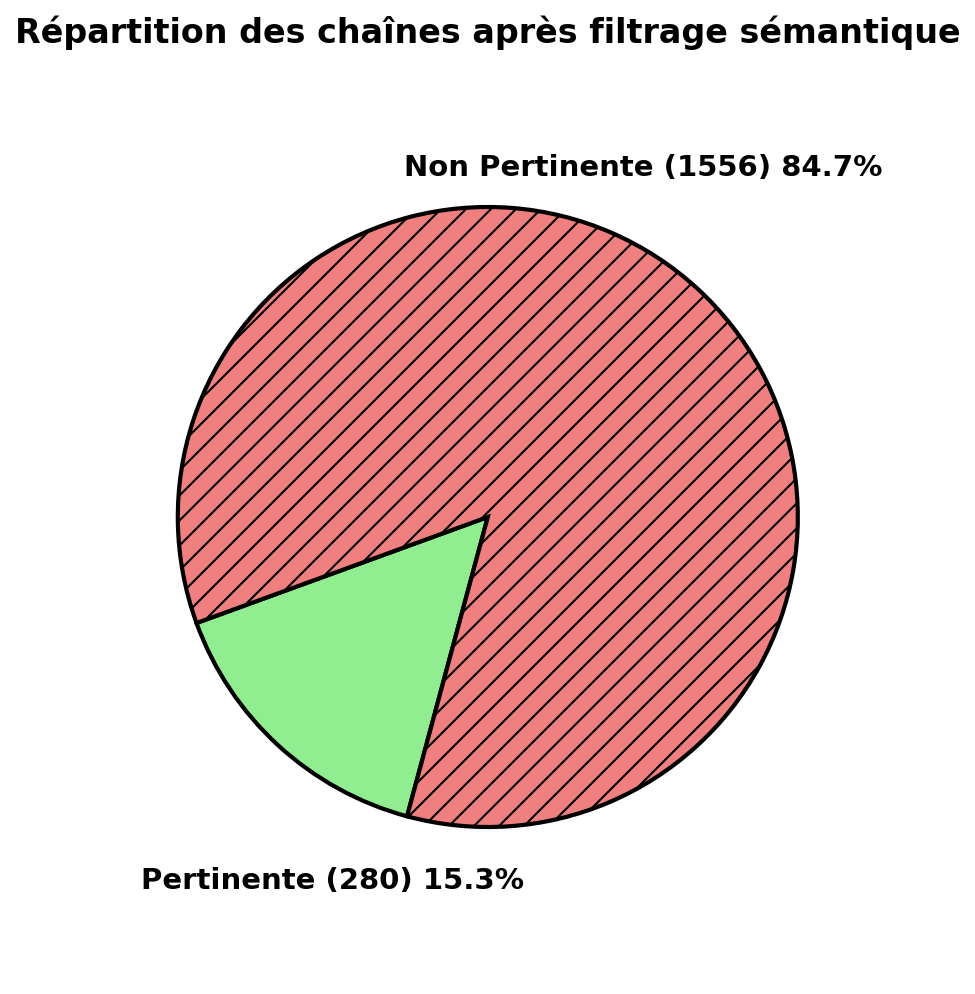

In [8]:
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

labels = ['Oui (Pertinent)', 'Non (Non Pertinent)']
sizes = [280, 1556]
colors = ['lightgreen', 'lightcoral']
explode = (0, 0.1)

angle_start = 200
angle_non = angle_start + (sizes[0] / sum(sizes)) * 360

fig, ax = plt.subplots(figsize=(8, 8), dpi=150)

w1 = Wedge(center=(0, 0), r=1, theta1=angle_start, theta2=angle_non,
           facecolor='lightgreen', edgecolor='black', lw=2, zorder=5)
w2 = Wedge(center=(0, 0), r=1, theta1=angle_non, theta2=angle_start + 360,
           facecolor='lightcoral', edgecolor='black', hatch='//', lw=2, zorder=5)

ax.add_patch(w1)
ax.add_patch(w2)

ax.text(-0.5, -1.2, f'Pertinente ({sizes[0]}) {sizes[0]/sum(sizes)*100:.1f}%', fontsize=14, ha='center', fontweight='bold', zorder=10)
ax.text(0.5, 1.1, f'Non Pertinente ({sizes[1]}) {sizes[1]/sum(sizes)*100:.1f}%', fontsize=14, ha='center', fontweight='bold', zorder=10)

ax.set_title("Répartition des chaînes après filtrage sémantique", fontsize=16, fontweight='bold')

ax.axis('equal')
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-1.5, 1.5)
ax.axis('off')

plt.show()


In [11]:
3057+1447

4504

In [13]:
3057/4504 

0.6787300177619894

In [10]:
280/1836

0.15250544662309368

# Excel pour Laura

In [5]:
channelsF3 = openJson("../jsons/channelsF3.json")
len(channelsF3)

334

In [6]:
import pandas as pd

data = []
for channel in channelsF3:
    
    data.append({
        "Nom Chaine": channel['nom_chaine'],
        "Bio": channel['bio'],
        "Très pertinente ? (oui)": "",
    })

df = pd.DataFrame(data)
df.to_excel("../xlsx/chaines_pertinentes.xlsx", index=False)
